In [1]:
#функция для перевода всех картинок в numpy

import os
import numpy as np
import cv2

def load_images_and_masks_from_directory(top_directory):
    image_list = []
    mask_list = []
    
    for case_folder in os.listdir(top_directory):
        case_folder_path = os.path.join(top_directory, case_folder)
        if os.path.isdir(case_folder_path):
            
            image_files = [f for f in os.listdir(case_folder_path) if f.endswith('.tif') and '_mask' not in f]
            
            for image_file in image_files:
                image_path = os.path.join(case_folder_path, image_file)
                mask_path = image_path.replace('.tif', '_mask.tif')
                
                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path, 0) 
                
                image_list.append(image)
                mask_list.append(mask)
    
    return np.array(image_list), np.array(mask_list)


In [1]:
#функция для перевода только тех картинок, у которых на маске что-то есть

import os
import cv2
import numpy as np

def load_images_and_masks_from_directory(top_directory):
    image_list = []
    mask_list = []
    
    for case_folder in os.listdir(top_directory):
        case_folder_path = os.path.join(top_directory, case_folder)
        if os.path.isdir(case_folder_path):
            image_files = [f for f in os.listdir(case_folder_path) if f.endswith('.tif') and '_mask' not in f]
            
            for image_file in image_files:
                image_path = os.path.join(case_folder_path, image_file)
                mask_path = image_path.replace('.tif', '_mask.tif')
                
                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path, 0) 

                # Проверяем, есть ли на маске какие-либо метки (среднее значение > 0)
                if np.mean(mask) > 0:
                    image_list.append(image)
                    mask_list.append(mask)
    
    return np.array(image_list), np.array(mask_list)


In [1]:
import albumentations as A

import os
import numpy as np
import cv2

from tqdm import tqdm

def load_images_and_masks_from_directory(top_directory):
    image_list = []
    mask_list = []

    # Создание трансформации для нормализации
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    
    for case_folder in tqdm(os.listdir(top_directory)):
        case_folder_path = os.path.join(top_directory, case_folder)
        if os.path.isdir(case_folder_path):
            
            image_files = [f for f in os.listdir(case_folder_path) if f.endswith('.tif') and '_mask' not in f]
            
            for image_file in image_files:
                image_path = os.path.join(case_folder_path, image_file)
                mask_path = image_path.replace('.tif', '_mask.tif')
                
                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path, 0)
                
                # Применение трансформации
                augmented = transform(image=image, mask=mask)
                image = augmented["image"]
                
                image_list.append(image)
                mask_list.append(mask)
    
    return np.array(image_list), np.array(mask_list)


In [2]:
images, masks = load_images_and_masks_from_directory('kaggle_3m/')

In [3]:
masks = masks.astype(np.float32)
masks[masks > 0.99] = 1

In [4]:
import matplotlib.pyplot as plt

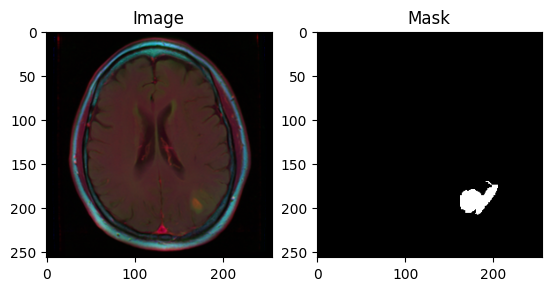

In [5]:
index = 66

plt.subplot(1, 2, 1)  
plt.imshow(images[index])
plt.title('Image')

plt.subplot(1, 2, 2)  
plt.imshow(masks[index], cmap='gray')  
plt.title('Mask')

plt.show()


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
import numpy as np
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Модель 1 (pspnet)

In [7]:
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

In [8]:
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))
#     return tf.maximum(0.0, x)

In [9]:
def ConvBlock(x, filters, kernel_size, strides, activation=mish):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = AttentionBlock(x)
#     x = cbam_block(x)
    x = layers.Dropout(0.2)(x)
    return x

In [10]:
def ResidualBlock(x, filters, kernel_size, strides):
    res = x
    x = ConvBlock(x, filters, kernel_size, strides)
    x = ConvBlock(x, filters, kernel_size, 1)
    res = layers.Conv2D(filters, 1, strides=strides, padding='same')(res)
    res = layers.BatchNormalization()(res)
    x = layers.Add()([x, res])
    x = layers.Activation(mish)(x)
    return x

In [11]:
def PyramidPoolingModule(x, pool_sizes):
    concat_layers = [x]
    h, w = x.shape[1], x.shape[2]
    
    for pool_size in pool_sizes:
        y = layers.AveragePooling2D(pool_size=pool_size, strides=pool_size, padding='same')(x)
        y = ResidualBlock(y, 256*8 // len(pool_sizes), 1, 1)
        y = ConvBlock(y, 256 // len(pool_sizes), 1, 1)
        y = tf.image.resize(y, (h, w), method=tf.image.ResizeMethod.BILINEAR)
        #y = AttentionBlock(y)
        concat_layers.append(y)
        
    return layers.Concatenate()(concat_layers)

In [12]:
def AttentionBlock(x):
    attention = layers.Conv2D(1, (3, 3), activation='sigmoid', kernel_initializer='he_normal', padding='same')(x)
    attention = layers.multiply([x, attention])
    attention = layers.BatchNormalization()(x)
    attention = layers.add([x, attention])

#     attention = layers.Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal', padding='same')(x)
#     attention = layers.multiply([x, attention])

    return attention

In [13]:
def PSPNet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    #x = PyramidPoolingModule(inputs, pool_sizes=[1, 2, 3, 4, 6, 8])
    
    x = ConvBlock(inputs, 32, 3, 2)
    x = ConvBlock(x, 32, 3, 1)
    
    skip1 = x
    x = ResidualBlock(x, 64, 3, 2)
    
    x = ConvBlock(x, 64, 3, 1)
    
    skip2 = x
    x = ResidualBlock(x, 128, 3, 2)
    x = ConvBlock(x, 128, 3, 1)
    
    skip3 = x
    x = ResidualBlock(x, 256, 3, 2)

    x = ConvBlock(x, 256, 3, 1)
    
    ###
    ###
    skip4 = x

    # Pyramid Pooling Module
    x = PyramidPoolingModule(x, pool_sizes=[1, 2, 3, 4, 6, 8, 10, 15])

    # Decoder
    ###
    ###
    #x = ConvBlock(x, 512, 3, 1)
    x = ConvBlock(x, 256, 3, 1)

    x = layers.concatenate([skip4, x])
    x = ConvBlock(x, 128, 3, 1)

    #x = ConvBlock(x, 512, 3, 1)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    
    x = ConvBlock(x, 64, 3, 1)

    x = layers.concatenate([skip3, x])
    x = ConvBlock(x, 32, 3, 1)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)

    x = ConvBlock(x, 32, 3, 1)

    x = layers.concatenate([skip2, x])
    x = ConvBlock(x, 32, 3, 1)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)

    x = ConvBlock(x, 32, 3, 1)
    x = layers.concatenate([skip1, x])
    x = ConvBlock(x, 32, 3, 1)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same')(x)
    
    x = ConvBlock(x, 8, 3, 1)

    x = ConvBlock(x, 4, 3, 1)

    # Output
    #x = ConvBlock(x, 1, 3, 1)
    
    #x = PyramidPoolingModule(x, pool_sizes=[1, 2, 3, 4, 6, 8, 10, 15])
    
    output = layers.Conv2D(1, 1, activation='sigmoid')(x)
    
    return Model(inputs=inputs, outputs=output)

In [14]:
input_shape = (256, 256, 3)
pspnet_model = PSPNet(input_shape)
pspnet_model.compile( optimizer= 'adam', loss=iou_loss, metrics=[iou])

# Модель 2 (дефолтный UNET)

In [7]:
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers

def encoder_block(input_tensor, num_filters, dropout):
    """ Функция для создания блока энкодера. """
    x = layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters, dropout):
    """ Функция для создания блока декодера. """
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = layers.concatenate([x, concat_tensor], axis=3)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    return x

def build_unet(input_size, First_layer, dropout):
    """ Функция для сборки модели U-Net. """
    inputs = tf.keras.layers.Input(input_size)

    # Энкодер
    c1, p1 = encoder_block(inputs, First_layer, dropout)
    c2, p2 = encoder_block(p1, First_layer*2, dropout)
    c3, p3 = encoder_block(p2, First_layer*4, dropout)
    c4, p4 = encoder_block(p3, First_layer*8, dropout)

    # Бутылочное горлышко
    c5 = layers.Conv2D(First_layer*16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(First_layer*16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    # Декодер
    c6 = decoder_block(c5, c4, First_layer*8, dropout)
    c7 = decoder_block(c6, c3, First_layer*4, dropout)
    c8 = decoder_block(c7, c2, First_layer*2, dropout)
    c9 = decoder_block(c8, c1, First_layer, dropout)

    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(c9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Создание и компиляция модели U-Net
model = build_unet((256, 256, 3), 32, 0.25)
model.compile(optimizer='adam', loss=iou_loss, metrics=[iou])


In [12]:
# tf.keras.utils.plot_model(pspnet_model, show_shapes=True)

In [9]:
from keras.callbacks import EarlyStopping, TensorBoard

parameters = {
    'monitor': 'val_loss',
    'restore_best_weights': True,
    'min_delta': 0.0001,
    'patience': 10,
    'verbose': 1,
    'baseline': 1.0,
}

early_stopping = EarlyStopping(**parameters)

log_dir = "logs/fit/unet" 
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

train = {
    'x': images,
    'y': masks,
    'epochs': 50,
    'validation_split': 0.2,
    'batch_size': 8,
    'callbacks': [early_stopping, tensorboard_callback]
}

In [16]:
history1 = pspnet_model.fit(**train)

Epoch 1/50
138/138 [==============================] - 25s 112ms/step - loss: 0.9072 - iou: 0.0924 - val_loss: 0.9717 - val_iou: 0.0280
Epoch 2/50
138/138 [==============================] - 13s 96ms/step - loss: 0.7830 - iou: 0.2185 - val_loss: 0.9680 - val_iou: 0.0317
Epoch 3/50
138/138 [==============================] - 14s 100ms/step - loss: 0.5908 - iou: 0.4092 - val_loss: 0.7025 - val_iou: 0.2959
Epoch 4/50
138/138 [==============================] - 13s 97ms/step - loss: 0.4595 - iou: 0.5388 - val_loss: 0.8191 - val_iou: 0.1777
Epoch 5/50
138/138 [==============================] - 13s 97ms/step - loss: 0.4163 - iou: 0.5832 - val_loss: 0.6390 - val_iou: 0.3546
Epoch 6/50
138/138 [==============================] - 13s 97ms/step - loss: 0.3906 - iou: 0.6091 - val_loss: 0.6822 - val_iou: 0.3122
Epoch 7/50
138/138 [==============================] - 13s 96ms/step - loss: 0.3468 - iou: 0.6542 - val_loss: 0.6440 - val_iou: 0.3497
Epoch 8/50
138/138 [==============================] - 13s 95

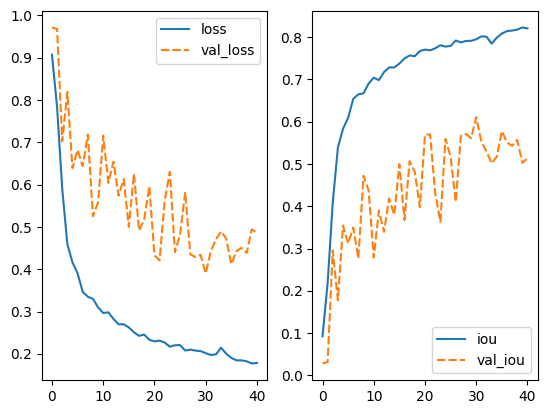

In [19]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(history1.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax = sns.lineplot(data=df[['iou', 'val_iou']], ax=axes[1])

In [10]:
history1 = model.fit(**train)

Epoch 1/50
138/138 [==============================] - 12s 76ms/step - loss: 0.5138 - iou: 0.4861 - val_loss: 0.9228 - val_iou: 0.0763
Epoch 2/50
138/138 [==============================] - 10s 71ms/step - loss: 0.4020 - iou: 0.5953 - val_loss: 0.8639 - val_iou: 0.1337
Epoch 3/50
138/138 [==============================] - 10s 74ms/step - loss: 0.3740 - iou: 0.6267 - val_loss: 0.6541 - val_iou: 0.3397
Epoch 4/50
138/138 [==============================] - 10s 71ms/step - loss: 0.3543 - iou: 0.6451 - val_loss: 0.6595 - val_iou: 0.3344
Epoch 5/50
138/138 [==============================] - 10s 72ms/step - loss: 0.3422 - iou: 0.6586 - val_loss: 0.6322 - val_iou: 0.3612
Epoch 6/50
138/138 [==============================] - 10s 72ms/step - loss: 0.3278 - iou: 0.6715 - val_loss: 0.6899 - val_iou: 0.3046
Epoch 7/50
138/138 [==============================] - 10s 72ms/step - loss: 0.3215 - iou: 0.6772 - val_loss: 0.6681 - val_iou: 0.3260
Epoch 8/50
138/138 [==============================] - 10s 73ms

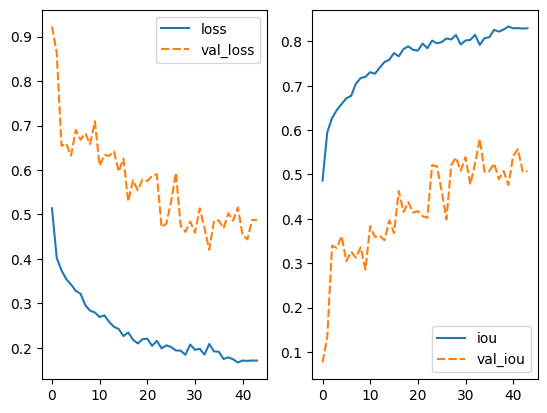

In [11]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(history1.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax = sns.lineplot(data=df[['iou', 'val_iou']], ax=axes[1])